In [1]:
import hats_import
from hats_import.catalog.arguments import ImportArguments
from dask.distributed import Client
from hats_import.pipeline import pipeline_with_client
import glob
import lsdb

import astropy.table
import numpy as np
import pyarrow as pa
import pyarrow.feather as feather
from astropy.io import fits

from hats_import.catalog.file_readers.input_reader import InputReader
from hats_import.catalog.file_readers.fits import FitsReader
import re
from upath import UPath
import astropy.units as u

### hats_import.catalog.file_readers.fits.py
overwrite read() function to join with columns from query table

In [2]:
class ZTFFitsReader(FitsReader):
    def __init__(
        self,
        fits_header_columns = None,
        external_columns = None,
        external_table_filename_prefix = None,
        **kwargs
    ):
        self.fits_header_columns = fits_header_columns
        self.external_columns = external_columns
        self.external_table_filename_prefix = external_table_filename_prefix
        super().__init__(**kwargs)

    def read(self, input_file, read_columns=None):
        input_file = self.regular_file_exists(input_file)
        for table_chunk in super().read(input_file, read_columns):
            if self.fits_header_columns is not None:
                fits_header = fits.getheader(input_file)
                n = len(table_chunk)
                for name in self.fits_header_columns:
                    table_chunk = table_chunk.add_column(0, name, pa.array([fits_header[name]]*n))

            # add metadata columns last so that IDs display first
            if self.external_columns is not None and self.external_table_filename_prefix is not None:
                meta_filename = (input_file.parent/("meta_" + input_file.name)).with_suffix(".feather")
                external_table = feather.read_table(meta_filename)
                n = len(table_chunk)
                for name in self.external_columns:
                    table_chunk = table_chunk.add_column(0, name, pa.array([external_table[name][0]]*n, type=external_table[name].type))
            else:
                assert(self.external_columns is None and self.external_table_filename_prefix is None)
            yield table_chunk

In [3]:
test_fits_header = fits.getheader('ztf_dr23/t_795_zr_c01_o_q1/ztf_20190613249421_000795_zr_c01_o_q1_psfcat.fits')

In [4]:
test_fits_header['MAGZP']

26.047115182713

# run fits import

In [5]:
external_columns = ['expid', 'rcid', 'obsjd', 'field']
fits_header_columns = ['MAGZP']
cat_name = 'TEST_ZTFFitsReader_2_all'

In [6]:
# args = ImportArguments(
#     # sort_columns="expid",
#     ra_column="ra",
#     dec_column="dec",
#     input_file_list = glob.glob(r"ztf_dr23\t_795_zr_c01_o_q1\ztf_*.fits"),
#     # input_file_list = ['ztf_dr23/t_795_zr_c01_o_q1/ztf_20190613249421_000795_zr_c01_o_q1_psfcat.fits'], # unit test file
#     file_reader= ZTFFitsReader(external_table_filename_prefix = "meta_", external_columns = external_columns, fits_header_columns = fits_header_columns), #
#     output_artifact_name=cat_name,
#     output_path="./output",
#     resume=False,
# )

In [7]:
client = Client(n_workers=4)

In [8]:
# pipeline_with_client(args, client)

In [9]:
test_cat = lsdb.open_catalog(f"output\{cat_name}")
print(len(test_cat))
test_cat.head()

12169415


,field,obsjd,rcid,expid,MAGZP,sourceid,xpos,ypos,ra,dec,flux,sigflux,mag,sigmag,snr,chi,sharp,flags
_healpix_29,,,,,,,,,,,,,,,,,,
706640038511694154,795,2458655.701157,0,90120115,26.026057,5976,462.752991,3065.052002,252.416743,51.854129,148.744644,28.166969,-5.431,0.206,5.28,0.911,-0.041,0
706640111120364455,795,2458655.685984,0,90118598,26.024383,2851,554.098999,3053.181885,252.371079,51.858007,160.958694,34.00819,-5.517,0.229,4.73,0.598,0.034,0
706640111301357200,795,2458655.701157,0,90120115,26.026057,5972,563.877014,3059.444092,252.371097,51.858123,123.70636,20.645523,-5.231,0.181,5.99,0.407,-0.095,0
706640130168008622,795,2458655.720891,0,90122089,26.019688,3592,465.303009,3067.528076,252.415799,51.854609,153.489319,49.592205,-5.465,0.351,3.1,1.158,-0.193,0
706640138273791634,795,2458660.745509,0,90624550,26.036355,10795,471.709991,3077.006104,252.406545,51.859292,44.980431,13.112123,-4.133,0.317,3.43,0.45,-0.01,0


C:\Users\lupin\OneDrive\Desktop\LINCC\hats\src\hats\inspection\visualize_catalog.py:298: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - TEST_ZTFFitsReader_2_all'}>)

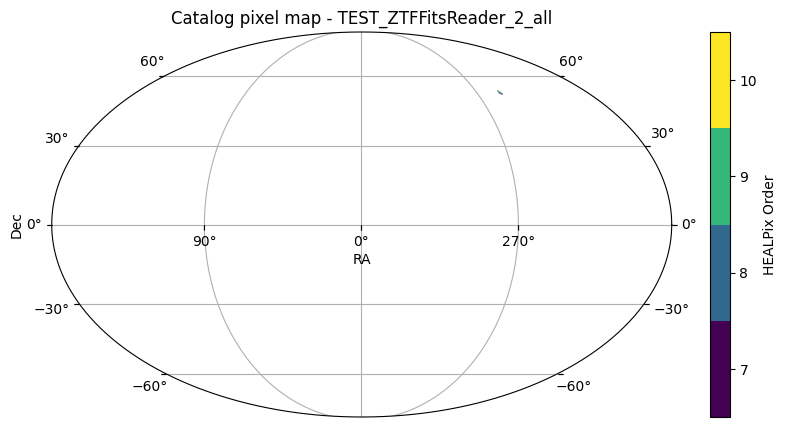

In [10]:
test_cat.plot_pixels()

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - TEST_ZTFFitsReader_2_all'}>)

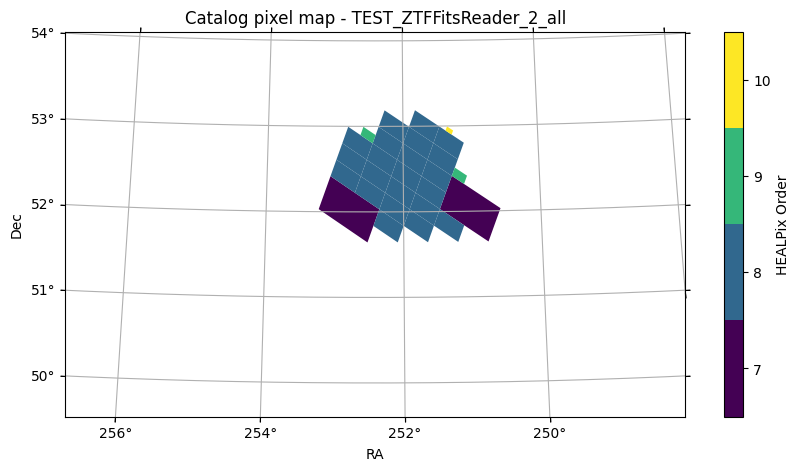

In [11]:
center = astropy.coordinates.SkyCoord(ra='252.416743d', dec='51.854129d', frame='icrs')
apparentDim = 5*u.deg
fov = (apparentDim, apparentDim)
test_cat.plot_pixels(fov=fov, center=center)

In [12]:
# test_cat.plot_points(fov=fov, center=center)

In [13]:
client.close()